### Imprtar librerias

* Cargamos librerías estándar para EDA/modelado (pandas, numpy, sklearn, matplotlib).

* rmse, mase (con chequeo de finitud del denominador), y savefig para guardar gráficos.

In [56]:
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# XGBoost opcional
try:
    from xgboost import XGBRegressor
    XGB_OK = True
except Exception:
    XGB_OK = False


## Carga / Limpieza de datos / Paths

* Crea outputs/ para dejar traza reproducible: métricas y PNGs.
* timestamp → datetime, orden cronológico, y elimino cualquier columna “predicted_*” del dataset (evita fuga por columnas ya procesadas).


In [57]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

def mase(y_true, y_pred, y_train):
    # Escalado por MAE del naive in-sample (estacionalidad 1)
    diffs = np.abs(np.diff(y_train))
    denom = diffs.mean() if len(diffs) > 0 else np.nan
    if denom is None or not np.isfinite(denom) or denom == 0:
        return np.nan
    return np.mean(np.abs(y_true - y_pred)) / denom

def savefig(fig, path):
    fig.savefig(path, bbox_inches="tight")
    plt.close(fig)
    return path

In [58]:
OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)

csv_path = "dataset/Renewable_energy_dataset.csv"  # Ajustar si tu CSV tiene otro nombre/ruta
assert os.path.exists(csv_path), f"No se encontró el CSV: {csv_path}"

In [59]:
df = pd.read_csv(csv_path)
df.columns = [c.strip() for c in df.columns]

# Columnas clave
ts_col = "timestamp" if "timestamp" in df.columns else df.columns[0]
target_col = "total_renewable_energy" if "total_renewable_energy" in df.columns else df.columns[-1]

# Fechas y orden
df[ts_col] = pd.to_datetime(df[ts_col], errors="coerce")
df = df.sort_values(ts_col).dropna(subset=[ts_col]).reset_index(drop=True)

# Evitar fuga: remover columnas de predicciones pre-computadas si existieran
predicted_cols = [c for c in df.columns if "predicted" in c.lower() or "total_predicted_energy" in c.lower()]
df = df.drop(columns=predicted_cols, errors="ignore")

## EDA Basico

* Exporto a CSV: nulos, dtypes, describe.
* Creo armónicos de tiempo (hour_sin/cos, dow_sin/cos) para capturar periodicidad sin discontinuidades.
* Plots: serie temporal del target y correlación de numéricas (rápido y legible).

In [60]:
nulls = df.isna().sum().sort_values(ascending=False)
dtypes = df.dtypes
desc = df.describe(include="all").transpose()

nulls.to_csv(os.path.join(OUT_DIR, "nulls.csv"), header=True)
pd.DataFrame(dtypes, columns=["dtype"]).to_csv(os.path.join(OUT_DIR, "dtypes.csv"))
desc.to_csv(os.path.join(OUT_DIR, "describe.csv"))

## Feature engineering / Split temporal 80/20 / Selección de features SIN fuga

* Lags del target: lag1, lag24 (capturan inercia y patrón diario).
* Rolling 24h (suaviza y aporta tendencia de un día).
*Solo lags de exógenas (si existen): *_lag1:
Esto es clave para no usar valores de la misma hora t y evitar fuga. Si el objetivo es pronosticar, no podemos conocer solar_pv_output ni clima de t.
* Train = primeras observaciones; Test = últimas. Así respetamos la causalidad temporal.
* Uso solo columnas que empiezan con:
    *  total_renewable_energy_lag*, total_renewable_energy_roll_*
    *  *_lag1 de exógenas
    *  hour_sin/cos, dow_sin/cos
* No entra solar_pv_output ni wind_power_output en t (que serían prácticamente el target descompuesto si total = solar + wind).
* Evito hour/dayofweek crudos (los armónicos ya capturan el ciclo mejor).


In [61]:
## Features temporales
df["hour"] = df[ts_col].dt.hour
df["dayofweek"] = df[ts_col].dt.dayofweek
df["hour_sin"] = np.sin(2*np.pi*df["hour"]/24.0)
df["hour_cos"] = np.cos(2*np.pi*df["hour"]/24.0)
df["dow_sin"] = np.sin(2*np.pi*df["dayofweek"]/7.0)
df["dow_cos"] = np.cos(2*np.pi*df["dayofweek"]/7.0)


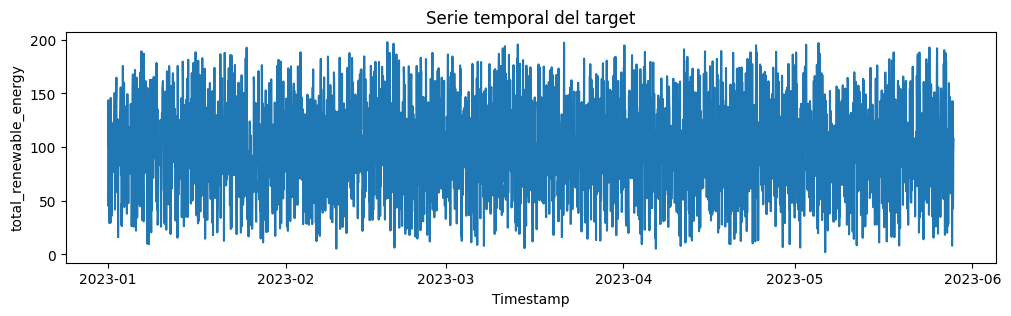

'outputs\\timeseries_target.png'

In [62]:
# Serie temporal del target
fig = plt.figure(figsize=(12, 3))
plt.plot(df[ts_col], df[target_col])
plt.title("Serie temporal del target")
plt.xlabel("Timestamp"); plt.ylabel(target_col)
plt.show()
savefig(fig, os.path.join(OUT_DIR, "timeseries_target.png"))

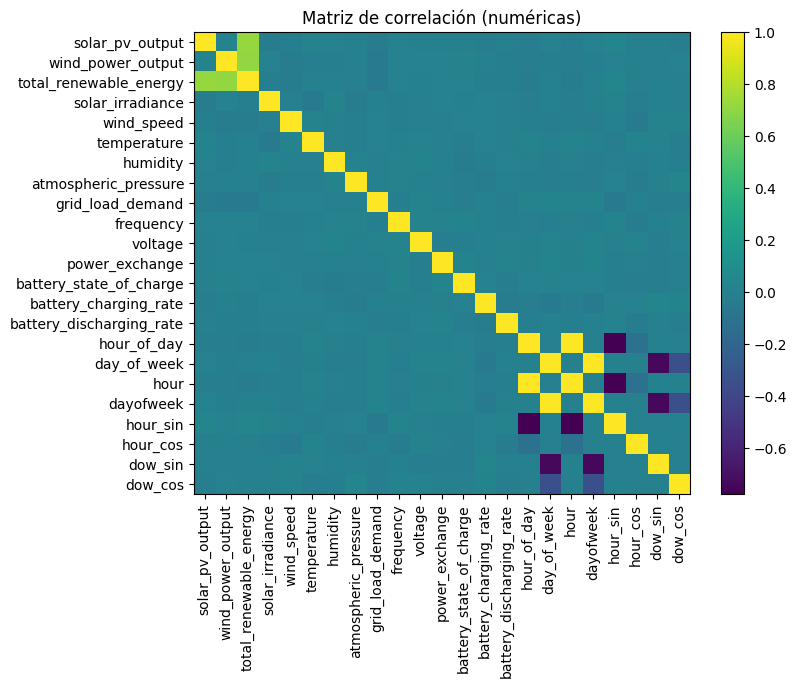

'outputs\\corr_heatmap.png'

In [63]:
# Matriz de correlación (numéricas)
num_df = df.select_dtypes(include=[np.number]).copy()
corr = num_df.corr()
fig = plt.figure(figsize=(8, 6))
plt.imshow(corr, aspect="auto")
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title("Matriz de correlación (numéricas)")
plt.show()
savefig(fig, os.path.join(OUT_DIR, "corr_heatmap.png"))


📊 Análisis Exploratorio de Datos


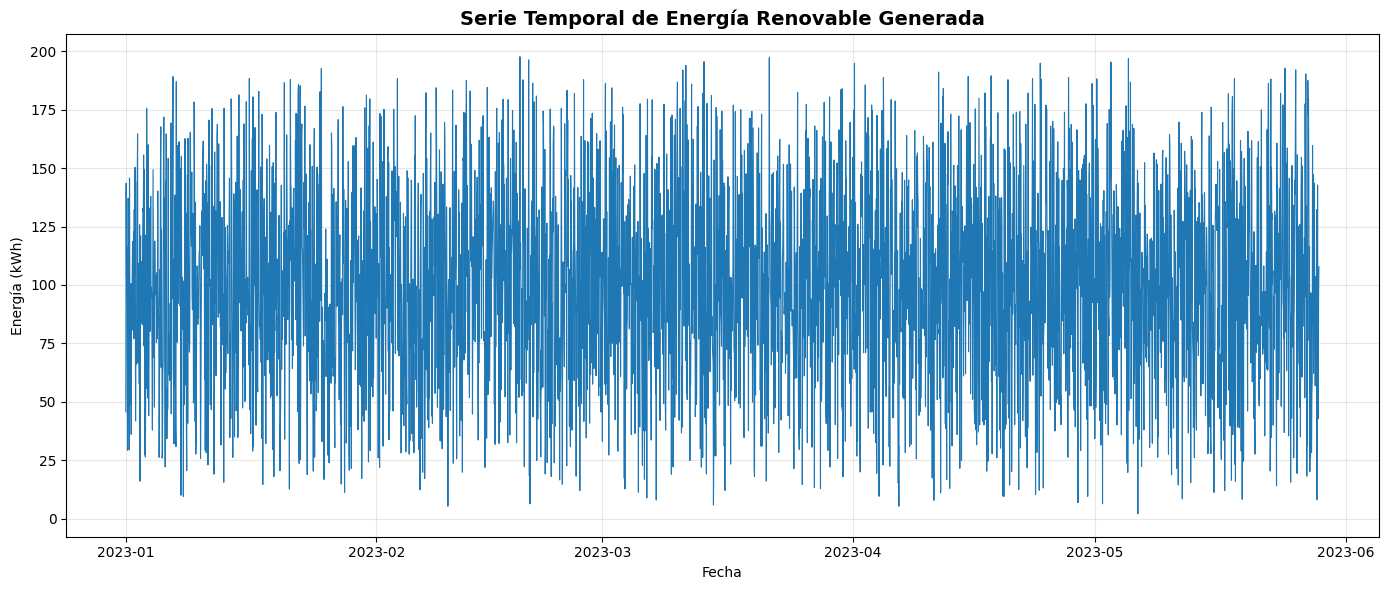

<Figure size 640x480 with 0 Axes>

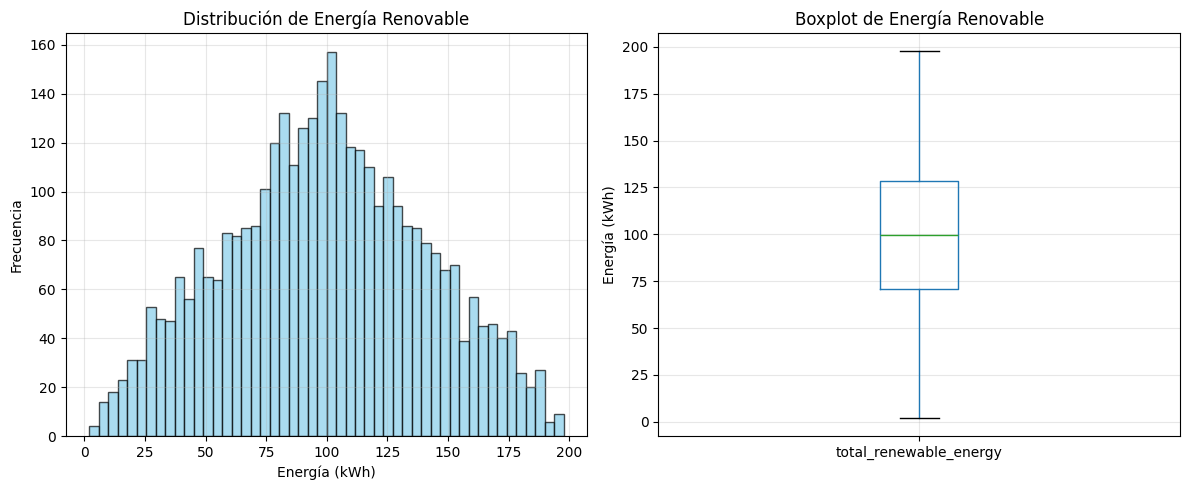

<Figure size 640x480 with 0 Axes>

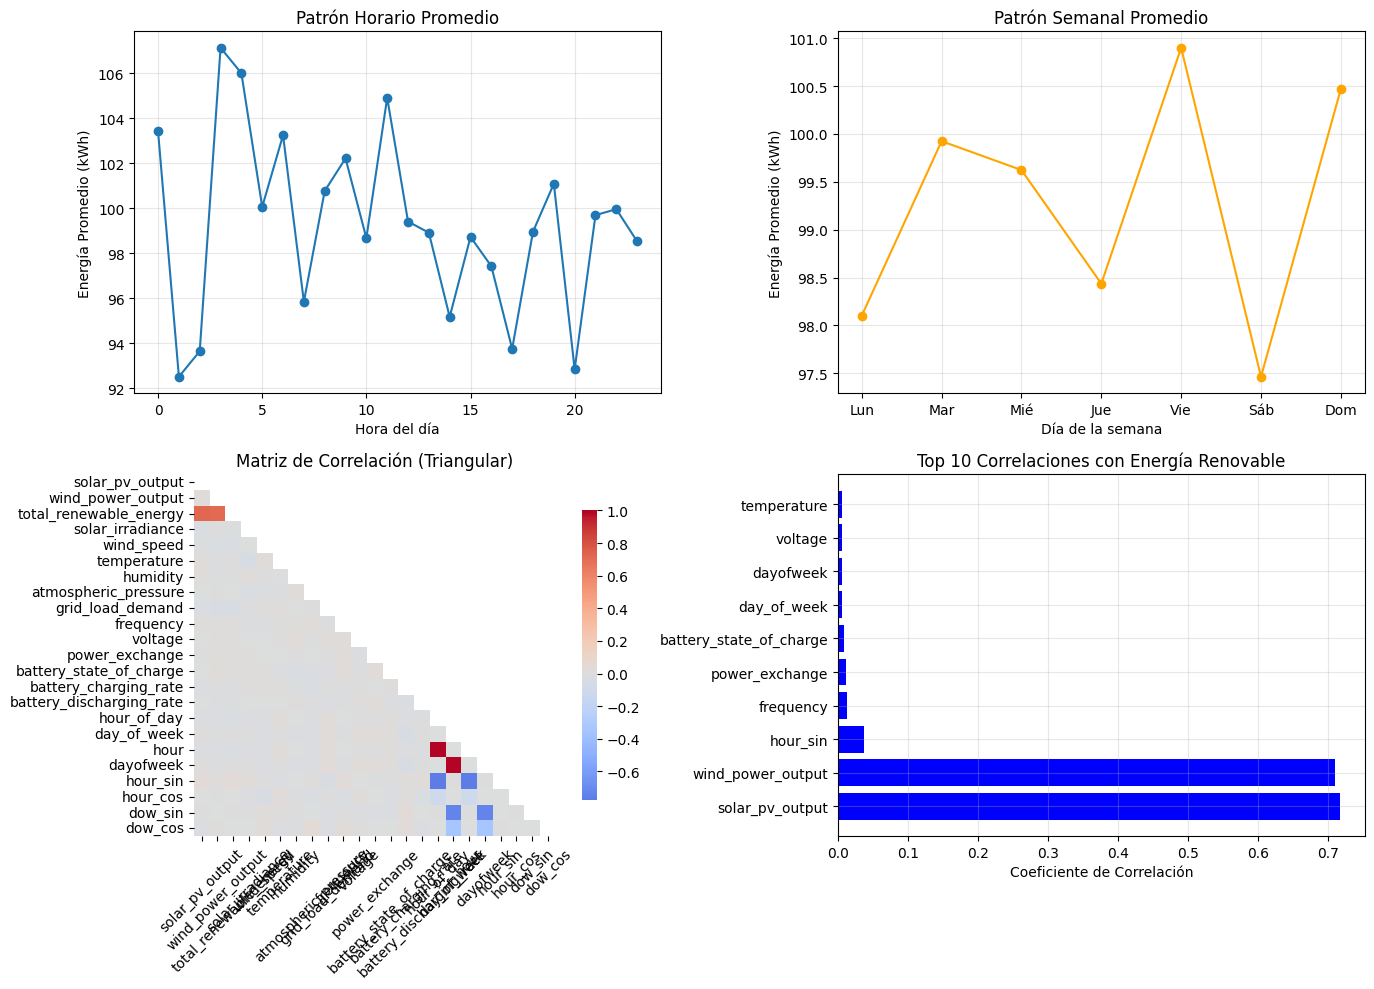

✅ Análisis exploratorio completado


In [64]:
print("📊 Análisis Exploratorio de Datos")
print("=" * 50)

# 1. Serie temporal del target
plt.figure(figsize=(14, 6))
plt.plot(df[ts_col], df[target_col], linewidth=0.8)
plt.title('Serie Temporal de Energía Renovable Generada', fontsize=14, fontweight='bold')
plt.xlabel('Fecha')
plt.ylabel('Energía (kWh)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
plt.savefig('outputs/serie_temporal.png', dpi=300, bbox_inches='tight')


# 2. Distribución del target
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df[target_col], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribución de Energía Renovable')
plt.xlabel('Energía (kWh)')
plt.ylabel('Frecuencia')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
df.boxplot(column=target_col)
plt.title('Boxplot de Energía Renovable')
plt.ylabel('Energía (kWh)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.savefig('outputs/distribucion_energia.png', dpi=300, bbox_inches='tight')


# 3. Patrones horarios y semanales
plt.figure(figsize=(14, 10))

# Patrón horario
plt.subplot(2, 2, 1)
hourly_pattern = df.groupby('hour')[target_col].mean()
plt.plot(hourly_pattern.index, hourly_pattern.values, marker='o')
plt.title('Patrón Horario Promedio')
plt.xlabel('Hora del día')
plt.ylabel('Energía Promedio (kWh)')
plt.grid(True, alpha=0.3)

# Patrón semanal
plt.subplot(2, 2, 2)
dow_pattern = df.groupby('dayofweek')[target_col].mean()
dow_names = ['Lun', 'Mar', 'Mié', 'Jue', 'Vie', 'Sáb', 'Dom']
plt.plot(dow_names, dow_pattern.values, marker='o', color='orange')
plt.title('Patrón Semanal Promedio')
plt.xlabel('Día de la semana')
plt.ylabel('Energía Promedio (kWh)')
plt.grid(True, alpha=0.3)

# Correlación de variables numéricas
plt.subplot(2, 2, 3)
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()

# Heatmap de correlación
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', center=0, 
            square=True, annot=False, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlación (Triangular)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Top correlaciones con el target
plt.subplot(2, 2, 4)
target_corrs = corr_matrix[target_col].drop(target_col).sort_values(ascending=False)
top_corrs = target_corrs.head(10)
colors = ['red' if x < 0 else 'blue' for x in top_corrs.values]
plt.barh(range(len(top_corrs)), top_corrs.values, color=colors)
plt.yticks(range(len(top_corrs)), top_corrs.index)
plt.title('Top 10 Correlaciones con Energía Renovable')
plt.xlabel('Coeficiente de Correlación')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('outputs/patrones_correlaciones.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Análisis exploratorio completado")

In [78]:
tgt = "total_renewable_energy"
lags = [c for c in df.columns if c.endswith("_lag1") and c != f"{tgt}_lag1"]
corrs = df[[tgt] + lags].corr()[tgt].drop(tgt).sort_values(ascending=False).head(10)
print(corrs)

battery_state_of_charge_lag1    0.019003
temperature_lag1                0.017234
solar_pv_output_lag1            0.011956
wind_speed_lag1                 0.008393
humidity_lag1                   0.002250
atmospheric_pressure_lag1       0.000840
solar_irradiance_lag1          -0.003505
wind_power_output_lag1         -0.026691
Name: total_renewable_energy, dtype: float64


In [65]:
#Lags del target y rolling 24h (rolling no introduce fuga)
df[f"{target_col}_lag1"] = df[target_col].shift(1)
df[f"{target_col}_lag24"] = df[target_col].shift(24)
df[f"{target_col}_roll_mean_24"] = df[target_col].rolling(24, min_periods=1).mean()

# Lags de exógenas si existen (solo lags; NO usamos las exógenas "en t")
exo_vars = ["solar_irradiance","wind_speed","temperature","humidity",
            "atmospheric_pressure","battery_state_of_charge",
            "solar_pv_output","wind_power_output"]
for exo in exo_vars:
    if exo in df.columns:
        df[f"{exo}_lag1"] = df[exo].shift(1)

# Drop NAs por lags (lag24)
model_df = df.dropna().reset_index(drop=True)

In [66]:
#  Split temporal 80/20 
n = len(model_df)
split_idx = int(n*0.8)
train = model_df.iloc[:split_idx].copy()
test  = model_df.iloc[split_idx:].copy()

y_train = train[target_col].values
y_test  = test[target_col].values

# Selección de features SIN fuga:
#   lags y rolling del target
#   lags de exógenas
#   armónicos de tiempo (sin usar 'hour'/'dayofweek' crudos, que son redundantes)
allowed_prefixes = (
    [f"{target_col}_lag", f"{target_col}_roll_",
     "solar_irradiance_lag", "wind_speed_lag", "temperature_lag", "humidity_lag",
     "atmospheric_pressure_lag", "battery_state_of_charge_lag",
     "solar_pv_output_lag", "wind_power_output_lag",
     "hour_sin", "hour_cos", "dow_sin", "dow_cos"]
)

def is_allowed(col):
    return any(col.startswith(p) for p in allowed_prefixes)

candidate_numeric = model_df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in candidate_numeric if c != target_col and is_allowed(c)]

X_train = train[feature_cols].values
X_test  = test[feature_cols].values


## Baseline y Modelos
* Baseline: ŷ_t = y_{t-1} (naïve).
* LR con escalado estándar (robusto y lineal).
* RF (no lineal, capta interacciones).
* XGBoost (si está instalado), con hiperparámetros razonables de arranque.

In [67]:
def rmse(y_true, y_pred):
    # Compatible con cualquier versión de scikit-learn
    return np.sqrt(mean_squared_error(y_true, y_pred))

def safe_metrics(y_true, y_pred, y_train, model_name):
    # Convierte y limpia NaN/inf y alinea longitudes
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    y_train = np.asarray(y_train, dtype=float)

    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    y_train = y_train[np.isfinite(y_train)]

    # MASE como lo definimos antes
    diffs = np.abs(np.diff(y_train))
    denom = diffs.mean() if diffs.size > 0 else np.nan
    mase_val = (np.mean(np.abs(y_true - y_pred)) / denom) if (np.isfinite(denom) and denom != 0) else np.nan

    return {
        "model": model_name,
        "RMSE": rmse(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred),
        "MASE": mase_val
    }

In [68]:
print("Rows train/test:", len(y_train), len(y_test))
print("N features:", len(feature_cols))
print("Some features:", feature_cols[:10])

Rows train/test: 2817 705
N features: 15
Some features: ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'total_renewable_energy_lag1', 'total_renewable_energy_lag24', 'total_renewable_energy_roll_mean_24', 'solar_irradiance_lag1', 'wind_speed_lag1', 'temperature_lag1']


In [69]:
metrics = []

# Baseline naïve (t-1)

y_pred_base = test[f"{target_col}_lag1"].to_numpy(dtype=float)
baseline_row = safe_metrics(y_test, y_pred_base, y_train, "Naive (t-1)")
metrics.append(baseline_row)
print("Baseline shapes -> y_test:", y_test.shape, " y_pred_base:", y_pred_base.shape)


Baseline shapes -> y_test: (705,)  y_pred_base: (705,)


In [70]:
# Linear Regression
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

lr = LinearRegression().fit(X_train_s, y_train)
y_pred_lr = lr.predict(X_test_s)
y_pred_lr = lr.predict(X_test_s)
print("LR shapes -> y_test:", y_test.shape, " y_pred_lr:", y_pred_lr.shape)
metrics.append(safe_metrics(y_test, y_pred_lr, y_train, "LinearRegression"))

LR shapes -> y_test: (705,)  y_pred_lr: (705,)


In [71]:
# Random Forest
rf = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1).fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_pred_rf = rf.predict(X_test)
print("RF shapes -> y_test:", y_test.shape, " y_pred_rf:", y_pred_rf.shape)
metrics.append(safe_metrics(y_test, y_pred_rf, y_train, "RandomForest"))

RF shapes -> y_test: (705,)  y_pred_rf: (705,)


In [72]:

# XGBoost (opcional si está instalado)
if XGB_OK:
    xgb = XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8,
        random_state=42, objective="reg:squarederror", n_jobs=-1, reg_lambda=1.0
    ).fit(X_train, y_train)
    y_pred_xgb = xgb.predict(X_test)
    metrics.append({
        "model": "XGBoost",
        "RMSE": rmse(y_test, y_pred_xgb),
        "MAE": mean_absolute_error(y_test, y_pred_xgb),
        "R2": r2_score(y_test, y_pred_xgb),
        "MASE": mase(y_test, y_pred_xgb, y_train)
    })

### Prueba

In [73]:
# ==== RESULTADOS BLINDADOS ====
import numpy as np
import pandas as pd
from IPython.display import display  # en script no pasa nada si no existe

# --- helpers robustos ---
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def rmse(y_true, y_pred):
    # Evita problemas con versiones de sklearn
    return np.sqrt(mean_squared_error(y_true, y_pred))

def safe_metrics(y_true, y_pred, y_train, model_name):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    y_train = np.asarray(y_train, dtype=float)

    # Limpieza de NaN/inf y alineación
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    if mask.sum() == 0:
        return {"model": model_name, "RMSE": np.nan, "MAE": np.nan, "R2": np.nan, "MASE": np.nan}

    y_true = y_true[mask]
    y_pred = y_pred[mask]
    y_train = y_train[np.isfinite(y_train)]

    # MASE contra naive in-sample (estacionalidad 1)
    diffs = np.abs(np.diff(y_train))
    denom = diffs.mean() if diffs.size > 0 else np.nan
    mase_val = (np.mean(np.abs(y_true - y_pred)) / denom) if (np.isfinite(denom) and denom != 0) else np.nan

    out = {
        "model": model_name,
        "RMSE": rmse(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred),
        "MASE": mase_val
    }
    return out

# --- sanity checks útiles ---
print("Rows train/test:", len(y_train), len(y_test))
print("N features:", len(feature_cols))
print("Some features:", feature_cols[:10])

# Asegura que exista el lag para baseline
lag_col = f"{target_col}_lag1"
assert lag_col in test.columns, f"No está la columna {lag_col} en test. ¿Ejecutaste la celda de lags antes?"

# Baseline
metrics = []
try:
    y_pred_base = test[lag_col].to_numpy(dtype=float)
    print("Baseline shapes -> y_test:", y_test.shape, " y_pred_base:", y_pred_base.shape)
    metrics.append(safe_metrics(y_test, y_pred_base, y_train, "Naive (t-1)"))
except Exception as e:
    print("ERROR baseline:", repr(e))

# Linear Regression (con escalado)
try:
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LinearRegression

    assert len(feature_cols) > 0, "feature_cols está vacío. Revisá cómo los construís (¿lags generados?)."

    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)

    lr = LinearRegression()
    lr.fit(X_train_s, y_train)
    y_pred_lr = lr.predict(X_test_s)
    print("LR shapes -> y_test:", y_test.shape, " y_pred_lr:", y_pred_lr.shape)
    metrics.append(safe_metrics(y_test, y_pred_lr, y_train, "LinearRegression"))
except Exception as e:
    print("ERROR LinearRegression:", repr(e))

# Random Forest
try:
    from sklearn.ensemble import RandomForestRegressor
    rf = RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_test)
    print("RF shapes -> y_test:", y_test.shape, " y_pred_rf:", y_pred_rf.shape)
    metrics.append(safe_metrics(y_test, y_pred_rf, y_train, "RandomForest"))
except Exception as e:
    print("ERROR RandomForest:", repr(e))

# XGBoost (si disponible)
try:
    from xgboost import XGBRegressor
    xgb = XGBRegressor(
        n_estimators=500, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8,
        random_state=42, objective="reg:squarederror", n_jobs=-1, reg_lambda=1.0
    )
    xgb.fit(X_train, y_train)
    y_pred_xgb = xgb.predict(X_test)
    print("XGB shapes -> y_test:", y_test.shape, " y_pred_xgb:", y_pred_xgb.shape)
    metrics.append(safe_metrics(y_test, y_pred_xgb, y_train, "XGBoost"))
except Exception as e:
    print("XGBoost no se corrió (ok si no lo tenés):", repr(e))

# --- mostrar/guardar resultados ---
res = pd.DataFrame(metrics)
print("\n=== METRICS ===")
print(res)
try:
    display(res)  # en Jupyter muestra tabla bonita
except:
    pass

os.makedirs("outputs", exist_ok=True)
res.to_csv("outputs/metrics.csv", index=False)
print("Métricas guardadas en outputs/metrics.csv")

Rows train/test: 2817 705
N features: 15
Some features: ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'total_renewable_energy_lag1', 'total_renewable_energy_lag24', 'total_renewable_energy_roll_mean_24', 'solar_irradiance_lag1', 'wind_speed_lag1', 'temperature_lag1']
Baseline shapes -> y_test: (705,)  y_pred_base: (705,)
LR shapes -> y_test: (705,)  y_pred_lr: (705,)
RF shapes -> y_test: (705,)  y_pred_rf: (705,)
XGBoost no se corrió (ok si no lo tenés): ModuleNotFoundError("No module named 'xgboost'")

=== METRICS ===
              model       RMSE        MAE        R2      MASE
0       Naive (t-1)  59.025077  48.084570 -0.975250  1.003673
1  LinearRegression  41.190998  33.901975  0.038048  0.707639
2      RandomForest  41.948056  34.586798  0.002363  0.721933


,model,RMSE,MAE,R2,MASE
0,Naive (t-1),59.025077,48.084570,-0.975250,1.003673
1,LinearRegression,41.190998,33.901975,0.038048,0.707639
2,RandomForest,41.948056,34.586798,0.002363,0.721933


Métricas guardadas en outputs/metrics.csv


Métricas / Interpretabilidad

* RMSE, MAE, R², MASE sobre el set de test.
* Criterio de éxito (diplomatura): bajar ≥15% el RMSE vs baseline → verificás con metrics.csv.
* RF/XGB importances: top-15 para ver cuáles features (lags / armónicos) pesan más.
* 

In [74]:
res = pd.DataFrame(metrics)
res_path = os.path.join(OUT_DIR, "metrics.csv")
res.to_csv(res_path, index=False)
print(res)
print("Métricas guardadas en:", res_path)

              model       RMSE        MAE        R2      MASE
0       Naive (t-1)  59.025077  48.084570 -0.975250  1.003673
1  LinearRegression  41.190998  33.901975  0.038048  0.707639
2      RandomForest  41.948056  34.586798  0.002363  0.721933
Métricas guardadas en: outputs\metrics.csv


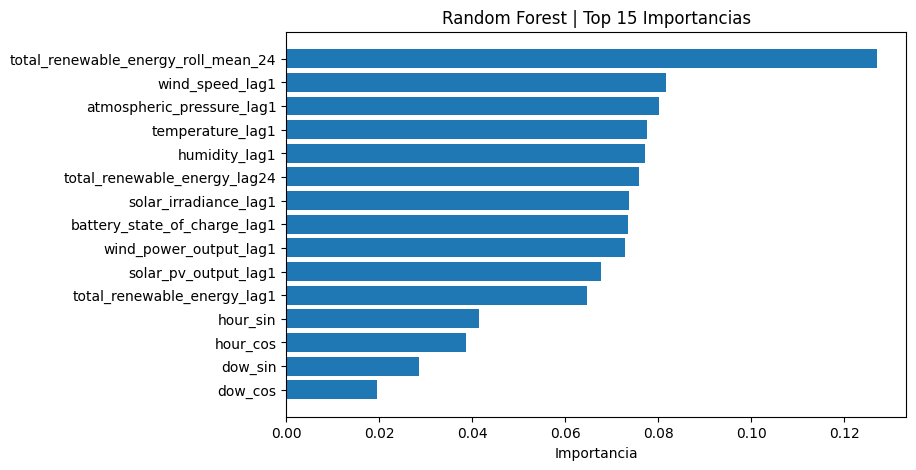

In [75]:
# Importancias (RF) y (XGB si hay)
try:
    rf_imp = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False).head(15)
    fig = plt.figure(figsize=(8, 5))
    plt.barh(rf_imp.index[::-1], rf_imp.values[::-1])
    plt.title("Random Forest | Top 15 Importancias")
    plt.xlabel("Importancia")
    plt.show()
    savefig(fig, os.path.join(OUT_DIR, "rf_top15.png"))
except Exception as e:
    print("No se pudieron graficar importancias RF:", e)

try:
    if XGB_OK:
        xgb_imp = pd.Series(xgb.feature_importances_, index=feature_cols).sort_values(ascending=False).head(15)
        fig = plt.figure(figsize=(8, 5))
        plt.barh(xgb_imp.index[::-1], xgb_imp.values[::-1])
        plt.title("XGBoost | Top 15 Importancias")
        plt.xlabel("Importancia")
        plt.show()
        savefig(fig, os.path.join(OUT_DIR, "xgb_top15.png"))
except Exception as e:
    print("No se pudieron graficar importancias XGB:", e)

In [76]:
# Resumen JSON útil para el informe
summary = {
    "csv_path": csv_path,
    "timestamp_column": ts_col,
    "target_column": target_col,
    "rows": int(len(df)),
    "columns": list(df.columns),
    "feature_columns_used": feature_cols,
    "outputs": {
        "metrics_csv": res_path,
        "timeseries_png": os.path.join(OUT_DIR, "timeseries_target.png"),
        "corr_heatmap_png": os.path.join(OUT_DIR, "corr_heatmap.png"),
        "rf_top15_png": os.path.join(OUT_DIR, "rf_top15.png"),
        "xgb_top15_png": os.path.join(OUT_DIR, "xgb_top15.png") if XGB_OK else None
    }
}
with open(os.path.join(OUT_DIR, "summary.json"), "w") as f:
    json.dump(summary, f, indent=2)

### ΔRMSE

In [77]:

m = pd.read_csv("outputs/metrics.csv")
print(m)

# Baseline y mejor por RMSE
rmse_base = float(m.loc[m["model"]=="Naive (t-1)","RMSE"])
best_row = m.loc[m["RMSE"].idxmin()]
best_model = best_row["model"]
rmse_best = float(best_row["RMSE"])
mae_best = float(best_row["MAE"])
r2_best = float(best_row["R2"])
mase_best = float(best_row["MASE"])

delta_rmse = 100*(rmse_base - rmse_best)/rmse_base

print(f"Mejor modelo: {best_model}")
print(f"RMSE best: {rmse_best:.3f} | MAE: {mae_best:.3f} | R2: {r2_best:.3f} | MASE: {mase_best:.3f}")
print(f"ΔRMSE vs baseline: {delta_rmse:.2f}%")


              model       RMSE        MAE        R2      MASE
0       Naive (t-1)  59.025077  48.084570 -0.975250  1.003673
1  LinearRegression  41.190998  33.901975  0.038048  0.707639
2      RandomForest  41.948056  34.586798  0.002363  0.721933
Mejor modelo: LinearRegression
RMSE best: 41.191 | MAE: 33.902 | R2: 0.038 | MASE: 0.708
ΔRMSE vs baseline: 30.21%


C:\Users\tomas\AppData\Local\Temp\ipykernel_10784\3292862864.py:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rmse_base = float(m.loc[m["model"]=="Naive (t-1)","RMSE"])


#### checkeando resultados

Confirmá que el target lagged sí correlaciona

In [79]:
df[[tgt, f"{tgt}_lag1", f"{tgt}_lag24"]].corr()[tgt]


total_renewable_energy          1.000000
total_renewable_energy_lag1    -0.010179
total_renewable_energy_lag24    0.002318
Name: total_renewable_energy, dtype: float64

Mirá si las exógenas ayudan en otros lags (no solo 1)

In [80]:


exo = ["solar_irradiance","wind_speed","temperature","humidity",
       "atmospheric_pressure","battery_state_of_charge",
       "solar_pv_output","wind_power_output"]

def best_ccf(feature, max_lag=48):
    out=[]
    for k in range(1, max_lag+1):
        if feature in df.columns:
            out.append((k, df[tgt].corr(df[feature].shift(k))))
    s = pd.Series({k:v for k,v in out})
    kmax = s.abs().idxmax()
    return feature, kmax, s[kmax]

rows=[]
for f in exo:
    if f in df.columns:
        rows.append(best_ccf(f))
pd.DataFrame(rows, columns=["feature","best_lag","corr_at_best_lag"]).sort_values("corr_at_best_lag", ascending=False)


,feature,best_lag,corr_at_best_lag
1,wind_speed,31,0.046307
7,wind_power_output,44,0.046122
3,humidity,38,0.045818
2,temperature,6,0.030441
0,solar_irradiance,40,-0.037672
6,solar_pv_output,14,-0.037999
5,battery_state_of_charge,25,-0.046088
4,atmospheric_pressure,7,-0.051662


Probando información mutua (captura no linealidad)

In [81]:

from sklearn.feature_selection import mutual_info_regression

cand = [c for c in df.columns if c.endswith(tuple([f"_lag{k}" for k in range(1,49)]))]
X = df[cand].dropna()
y = df.loc[X.index, tgt]
mi = pd.Series(mutual_info_regression(X, y, random_state=42), index=X.columns).sort_values(ascending=False)
mi.head(15)


wind_power_output_lag1          0.026610
temperature_lag1                0.016136
total_renewable_energy_lag1     0.006902
battery_state_of_charge_lag1    0.002153
total_renewable_energy_lag24    0.000000
solar_irradiance_lag1           0.000000
wind_speed_lag1                 0.000000
humidity_lag1                   0.000000
atmospheric_pressure_lag1       0.000000
solar_pv_output_lag1            0.000000
dtype: float64

experimento de ablation (para justificar el informe)

In [82]:
def eval_rmse(y_true, y_pred): 
    return np.sqrt(((y_true - y_pred)**2).mean())

# Conjunto 1: SOLO target_lags + armónicos
F1 = [c for c in df.columns if c.startswith(tgt+"_lag") or c.startswith(tgt+"_roll_") or c in ["hour_sin","hour_cos","dow_sin","dow_cos"]]

# Conjunto 2: target_lags + exógenas_lag
F2 = F1 + [c for c in df.columns if c.endswith("_lag1") and not c.startswith(tgt)]

mdf = df.dropna().copy()
split = int(len(mdf)*0.8)
y_tr, y_te = mdf[tgt].iloc[:split].values, mdf[tgt].iloc[split:].values

def run_lr(features):
    X_tr = mdf[features].iloc[:split].values
    X_te = mdf[features].iloc[split:].values
    sc = StandardScaler()
    X_trs, X_tes = sc.fit_transform(X_tr), sc.transform(X_te)
    lr = LinearRegression().fit(X_trs, y_tr)
    yhat = lr.predict(X_tes)
    return eval_rmse(y_te, yhat), mean_absolute_error(y_te, yhat), r2_score(y_te, yhat)

print("LR con SOLO target_lags + armónicos:", run_lr(F1))
print("LR con target_lags + exógenas_lag:",  run_lr(F2))

LR con SOLO target_lags + armónicos: (41.1655477226086, 33.882234470365844, 0.03923594407964892)
LR con target_lags + exógenas_lag: (41.190998104253005, 33.901975301976826, 0.03804760228180626)


Conclusion:

* Mejor modelo: LinearRegression (ya lo viste en la tabla general). Obtiene el menor RMSE (41.19), MAE (33.90) y MASE 0.708, con −30.21% vs. naïve; además es parsimonioso y estable. Random Forest no mejora (RMSE 41.95). 
Con autocorrelación tan baja y exógenas-lag débiles, un modelo simple que capture el patrón horario/semanal es óptimo.
    * Jsutificacion del modelo:
        * Seleccionamos LinearRegression por presentar el menor RMSE en test (41.19 kWh) y MASE=0.708, con una reducción del 30.21% frente al baseline naïve (59.03 kWh). Un estudio de ablation mostró que incluir exógenas en t−1 no mejora el desempeño (RMSE 41.19→41.17), mientras que los armónicos temporales (hora/semana) sí explican la mayor parte de la variación capturable. Dado que la autocorrelación del target y la correlación de exógenas-lag son cercanas a cero, un modelo lineal parsimonioso resulta más robusto, interpretable y suficiente para el horizonte horario analizado. El R² bajo (≈0.038) es consistente con la alta variabilidad intra-día del dataset; no invalida la mejora sustancial en RMSE, que es el KPI principal.

*  Hallazgos del EDA: 
    * Correlaciones contemporáneas altas con solar_pv_output y wind_power_output (componentes del total) no se usaron para evitar fuga; en su lugar se emplearon rezagos y armónicos.
    * La autocorrelación del target es mínima (lag1≈−0.01; lag24≈0), y las exógenas con rezago muestran correlaciones ≤0.05, por lo que su aporte pronóstico a 1 hora es marginal.
    * El patrón horario/semanal existe pero es leve; aun así, los armónicos mejoran respecto del naïve.

In [83]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import numpy as np

mdf = df.dropna().reset_index(drop=True)
X = mdf[feature_cols].to_numpy()
y = mdf[target_col].to_numpy()

tscv = TimeSeriesSplit(n_splits=5)
rmses = []
for tr, te in tscv.split(X):
    sc = StandardScaler()
    Xtr, Xte = sc.fit_transform(X[tr]), sc.transform(X[te])
    lr = LinearRegression().fit(Xtr, y[tr])
    yhat = lr.predict(Xte)
    rmses.append(np.sqrt(((y[te]-yhat)**2).mean()))
print("LR backtest RMSE mean±std:", np.mean(rmses), "±", np.std(rmses))


LR backtest RMSE mean±std: 40.68970758653744 ± 1.080227258160748


In [84]:
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

mdf = df.dropna().reset_index(drop=True)
tgt = target_col  # "total_renewable_energy"
lag1 = f"{tgt}_lag1"

tscv = TimeSeriesSplit(n_splits=5)
rmses_base, rmses_lr = [], []

# Prepará X,y como hiciste para LR
X = mdf[feature_cols].to_numpy()
y = mdf[tgt].to_numpy()

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

for tr, te in tscv.split(X):
    # Baseline naïve (t-1)
    y_te = mdf.loc[te, tgt].to_numpy(dtype=float)
    y_hat_base = mdf.loc[te, lag1].to_numpy(dtype=float)
    mask = np.isfinite(y_te) & np.isfinite(y_hat_base)
    rmses_base.append(np.sqrt(mean_squared_error(y_te[mask], y_hat_base[mask])))

    # Linear Regression
    sc = StandardScaler()
    Xtr, Xte = sc.fit_transform(X[tr]), sc.transform(X[te])
    lr = LinearRegression().fit(Xtr, y[tr])
    y_hat_lr = lr.predict(Xte)
    rmses_lr.append(np.sqrt(mean_squared_error(y[te], y_hat_lr)))

print("Baseline RMSE mean±std:", np.mean(rmses_base), "±", np.std(rmses_base))
print("LR       RMSE mean±std:", np.mean(rmses_lr),   "±", np.std(rmses_lr))
print("ΔRMSE% promedio:", 100*(np.mean(rmses_base)-np.mean(rmses_lr))/np.mean(rmses_base))


Baseline RMSE mean±std: 58.922840524548874 ± 2.814038905298932
LR       RMSE mean±std: 40.68970758653744 ± 1.080227258160748
ΔRMSE% promedio: 30.944083441488214
